<hr style="border:2px solid #808080"> </hr>
<center><h1 style="color:#03122E;"> Álgebra Lineal Numérica IMT2111</h1></center>
<center><h1 style="color:#173F8A;"> Capítulo 4: Multigrid</h3></center>
<center><h1 style="color:#0176DE;"> Prof. Manuel A. Sánchez</h3></center>
<hr style="border:2px solid #808080"> </hr>

Problema de Poisson en un Intervalo:
\begin{equation}
-u''(x) = f(x),\quad \mbox{ en }(0,1), \qquad u(0) = u(1) = 0. 
\end{equation}

Metodo de diferencias finitas centradas: Malla $\{x_j\},\,0\geq j\geq n$, $x_j = j \Delta x$, $\Delta x = 1/n$. Encontrar $u_j$, $1\leq j \leq n-1$, y con $u_0=u_n=0$, soluci\'on de
\begin{equation}
\frac{-u_{j+1}+2u_j-u_{j-1}}{\Delta x^{2}} = f(x_j), \qquad 1\leq j \leq n-1.
\end{equation}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

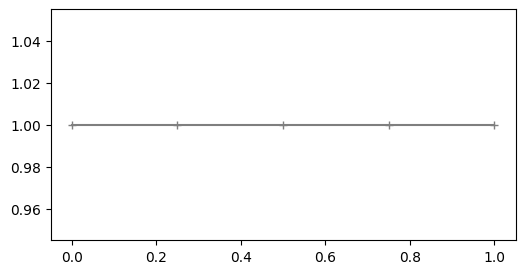

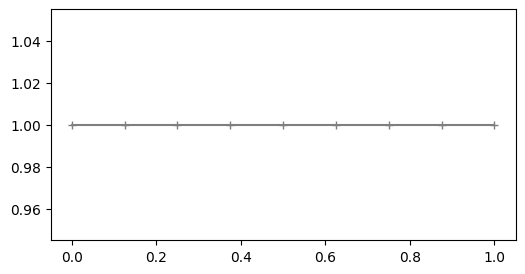

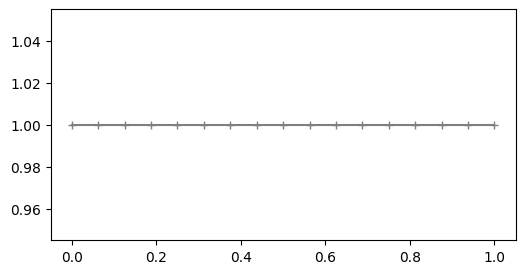

In [31]:
class mesh1d:
    def __init__(self, a = 0.0, b=1.0):
        self.a = a
        self.b = b
    def generate_uniform(self, n=1):
        self.h = (self.b-self.a)/n
        self.x = np.zeros(n+1, dtype=np.float64)
        for j in range(n+1):
            self.x[j] = self.a+j*self.h
    def refine(self):
        xold = self.x
        midpoint = np.zeros(xold.size-1, dtype=np.float64)
        xnew = np.zeros(2*xold.size-1, dtype=np.float64)
        for j in range(xold.size-1):
            midpoint[j] = 0.5*(xold[j+1]+xold[j])
            xnew[2*j] = xold[j]
            xnew[2*j+1] = midpoint[j]
        xnew[-1] = xold[-1]
        self.x = xnew
        self.h = self.h*0.5
    def plot(self):
        fig,ax = plt.subplots(1,1,figsize=(6,3))
        ax.plot(self.x, np.ones(self.x.size), '+-', color='C07')

def diff1dPoissonmatrix(a=0, b=1, n=5):
    deltax = (b-a)/n
    A = 2.0/(deltax**2)*np.eye(n-1) -1.0/(deltax**2)*np.diag(np.ones(n-2),-1) - 1.0/(deltax**2)*np.diag(np.ones(n-2),1)
    return A

# Problema de Poisson: -u'' = f 
ufun1D = lambda x: np.sin(2*np.pi*x)
f = lambda x: 4*np.pi**2*np.sin(2*np.pi*x)
# Grilla de diferencias finitas
n = 4
mesh = mesh1d(a=0.0, b=1.0)
mesh.generate_uniform(n=n)
mesh.plot()
X = mesh.x

mesh.refine()
mesh.plot()

mesh.refine()
mesh.plot()

# Matriz de diferencias finitas
A1d = diff1dPoissonmatrix(n=n)
# vector de diferencias finitas
b1d = np.asarray([f(X[j]) for j in range(1,n) ])

# Resolvermos el sistema lineal
u = np.zeros(n+1, dtype=np.float64)
u[1:n] = np.linalg.solve(A1d, b1d)

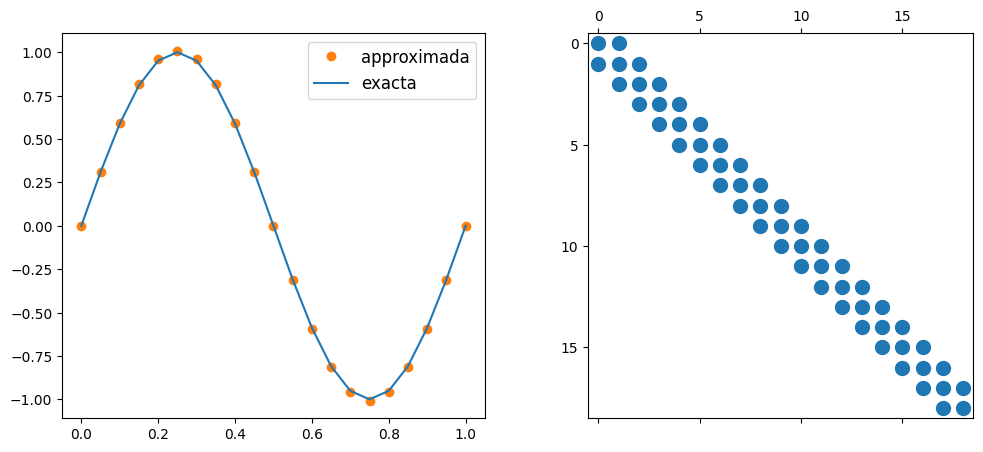

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[1].spy(A1d,  marker='o')
ax[0].plot(X, u,color='C01', marker='o', linestyle='None', label='approximada')
ax[0].plot(X, ufun1D(X), label='exacta')
ax[0].legend(loc="best", fontsize=12)
plt.show()

In [ ]:


def f(x):
    return np.sin(np.pi * x)

def exact_solution(x):
    return np.sin(np.pi * x) / (np.pi**2)

def initialize_grid(N):
    h = 1.0 / (N + 1)
    x = np.linspace(0, 1, N + 2)
    u = np.zeros_like(x)
    f_vec = f(x)
    return x, u, f_vec, h

def residual(u, f_vec, h):
    r = np.zeros_like(u)
    r[1:-1] = f_vec[1:-1] - (u[:-2] - 2*u[1:-1] + u[2:]) / h**2
    return r

def gauss_seidel(u, f_vec, h, omega=1.0, iterations=1):
    N = len(u) - 2
    for _ in range(iterations):
        for i in range(1, N + 1):
            u[i] = (1 - omega) * u[i] + omega * 0.5 * (u[i-1] + u[i+1] - h**2 * f_vec[i])
    return u

def restrict(r):
    N = len(r) - 2
    Nc = N // 2
    rc = np.zeros(Nc + 2)
    rc[1:-1] = 0.25 * r[1:-2:2] + 0.5 * r[2:-1:2] + 0.25 * r[3::2]
    return rc

def prolong(uc):
    N = 2 * (len(uc) - 2)
    u = np.zeros(N + 2)
    u[1:-1:2] = uc[1:-1]
    u[2::2] = 0.5 * (uc[1:-1] + uc[2:])
    return u

def multigrid(u, f_vec, h, v_cycles=1, pre_smoothing=3, post_smoothing=3):
    if len(u) - 2 <= 2:
        return gauss_seidel(u, f_vec, h, iterations=10)
    
    for _ in range(v_cycles):
        u = gauss_seidel(u, f_vec, h, iterations=pre_smoothing)
        r = residual(u, f_vec, h)
        rc = restrict(r)
        ec = np.zeros_like(rc)
        hc = 2 * h
        ec = multigrid(ec, rc, hc)
        e = prolong(ec)
        u += e
        u = gauss_seidel(u, f_vec, h, iterations=post_smoothing)
    
    return u

# Parámetros del problema
N = 63
x, u, f_vec, h = initialize_grid(N)
u = multigrid(u, f_vec, h)

# Solución exacta
u_exact = exact_solution(x)

# Gráfica de la solución numérica vs exacta
plt.plot(x, u, label='Solución Numérica (Multigrid)')
plt.plot(x, u_exact, label='Solución Exacta', linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Solución de -u\'\' = f usando Multigrid')
plt.show()
